In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import os
import torch
from tqdm import tqdm

pd.set_option('display.max_colwidth', None)

# 1,000 단위 표기
pd.options.display.float_format = '{:,.3f}'.format

# Unicode warning 제거 (폰트 관련 경고메시지)
plt.rcParams['axes.unicode_minus']=False

# 그래프 출력 사이즈 설정
plt.rcParams["figure.figsize"] = (10, 6)

# 경고 무시
warnings.filterwarnings('ignore')

# Data 경로 설정
DATA_DIR = 'data'

# 시드설정
SEED = 123

def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

%matplotlib inline

In [2]:
import FinanceDataReader as fdr

df = fdr.DataReader('BTC/USD')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864,468.174,452.422,457.334,457.334,21056800
2014-09-18,456.860,456.860,413.104,424.440,424.440,34483200
2014-09-19,424.103,427.835,384.532,394.796,394.796,37919700
2014-09-20,394.673,423.296,389.883,408.904,408.904,36863600
2014-09-21,408.085,412.426,393.181,398.821,398.821,26580100


In [63]:
df['Close']

Date
2014-09-17      457.334
2014-09-18      424.440
2014-09-19      394.796
2014-09-20      408.904
2014-09-21      398.821
                ...    
2023-06-29   30,445.352
2023-06-30   30,477.252
2023-07-01   30,590.078
2023-07-02   30,620.770
2023-07-03   30,747.822
Name: Close, Length: 3212, dtype: float64

In [64]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
series = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
series[:5]

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       [0.00342492],
       [0.0032753 ]])

## Windowed Dataset

In [204]:
N_PREDICTIONS = 1
WINDOW_SIZE = 30

In [205]:
def make_dataset(series, window_size=WINDOW_SIZE, n_predictions=N_PREDICTIONS):
    Xs = []
    Ys = []
    for i in range(len(series) - window_size - n_predictions +1):
        Xs.append(series[i:i+window_size])
        Ys.append(series[i+window_size: i+window_size+n_predictions])
    return np.array(Xs), np.array(Ys)

In [206]:
# 데이터셋 생성
Xs, Ys = make_dataset(series.flatten())

In [207]:
Xs = np.expand_dims(Xs, -1)
Xs.shape, Ys.shape

((3182, 30, 1), (3182, 1))

In [208]:
n_splits = 50

x_train, y_train = Xs[:-n_splits], Ys[:-n_splits]
x_valid, y_valid = Xs[-n_splits:], Ys[-n_splits:]

In [209]:
x_train.shape, y_train.shape

((3132, 30, 1), (3132, 1))

In [210]:
x_valid.shape, y_valid.shape

((50, 30, 1), (50, 1))

In [211]:
df['Close'].tail(6)

Date
2023-06-28   30,086.246
2023-06-29   30,445.352
2023-06-30   30,477.252
2023-07-01   30,590.078
2023-07-02   30,620.770
2023-07-03   30,747.822
Name: Close, dtype: float64

In [212]:
x_valid[-1]

array([[0.39913243],
       [0.39978444],
       [0.37961832],
       [0.40156095],
       [0.38831266],
       [0.39071987],
       [0.39030672],
       [0.38097081],
       [0.38229043],
       [0.38173147],
       [0.38197229],
       [0.37018912],
       [0.3768923 ],
       [0.38803761],
       [0.39075636],
       [0.38816745],
       [0.39580696],
       [0.41771654],
       [0.44294047],
       [0.44123373],
       [0.45285566],
       [0.45067765],
       [0.44966215],
       [0.44655879],
       [0.45274727],
       [0.44381524],
       [0.4491441 ],
       [0.44961748],
       [0.45129174],
       [0.45174718]])

In [213]:
y_valid[-1]

array([0.45363255])

## Tensor DataSet 생성

In [214]:
def make_tensor(x, device):
    return torch.FloatTensor(x).to(device)

In [215]:
# device 설정 (cuda 혹은 cpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [216]:
x_train = make_tensor(x_train, device=device)
y_train = make_tensor(y_train, device=device)
x_valid = make_tensor(x_valid, device=device)
y_valid = make_tensor(y_valid, device=device)

In [217]:
train_ds = torch.utils.data.TensorDataset(x_train, y_train)
valid_ds = torch.utils.data.TensorDataset(x_valid, y_valid)

## DataLoader 생성

In [218]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=train_ds, 
                                           batch_size=batch_size, 
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_ds, 
                                          batch_size=batch_size, 
                                          shuffle=False)

## 모델

In [219]:
import torch
import torch.nn as nn
import torch.optim as optim

In [220]:
class BaseModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, bidirectional=True):
        super(BaseModel, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = 2 if bidirectional else 1
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            bidirectional=bidirectional,
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size*self.bidirectional, 64)
        self.relu = nn.ReLU()
        self.out = nn.Linear(64, output_size)
        
    def init_hidden_and_cell_state(self, batch_size, device):
        self.hidden_and_cell = (
            torch.zeros(self.num_layers*self.bidirectional, batch_size, self.hidden_size).to(device),
            torch.zeros(self.num_layers*self.bidirectional, batch_size, self.hidden_size).to(device),
        )
        
    def forward(self, x):
        output, (h, c) = self.lstm(x, self.hidden_and_cell)
        h = output[:, -1, :]
        o = self.relu(self.fc(h))
        o = self.out(o)
        return o

In [221]:
config = {
    'input_size': 1,
    'hidden_size': 32, 
    'num_layers': 2, 
    'bidirectional': False,
    'output_size': N_PREDICTIONS, 
    
}

model = BaseModel(**config)

In [222]:
x, y = next(iter(train_loader))
x.to(device), y.to(device)

model = model.to(device)
model.init_hidden_and_cell_state(batch_size, device)
output = model(x)

In [223]:
output.shape

torch.Size([32, 1])

## 손실함수 & 옵티마이저 정의

In [ ]:
model = model.to(device)
loss_fn = nn.HuberLoss()

In [235]:
lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr)

## 모델 훈련

In [225]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    
    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader, unit='batch', total=len(data_loader), mininterval=1)
    
    # mini-batch 학습을 시작합니다.
    for idx, (xs, ys) in enumerate(prograss_bar):
        # txt, lbl 데이터를 device 에 올립니다. (cuda:0 혹은 cpu)
        xs = xs.to(device)
        ys = ys.to(device)
        
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()
        
        # LSTM Weight 초기화
        model.init_hidden_and_cell_state(len(xs), device)
        
        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(xs)
        
        # 손실함수에 output, lbl 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, ys)
        
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()
        
        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()
        
        # batch 별 loss 계산하여 누적합을 구합니다.
        running_loss += loss.item()
        
        # 프로그레스바에 학습 상황 업데이트
        prograss_bar.set_description(f"training loss: {running_loss/(idx+1):.5f}")
        
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss
    return running_loss / len(data_loader)

In [226]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0
        
        # 배치별 evaluation을 진행합니다.
        for xs, ys in data_loader:
            # txt, lbl 데이터를 device 에 올립니다. (cuda:0 혹은 cpu)
            xs = xs.to(device)
            ys = ys.to(device)
            
            # LSTM Weight 초기화
            model.init_hidden_and_cell_state(len(xs), device)
    
            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(xs)
            
            # 검증 손실을 구합니다.
            loss = loss_fn(output, ys)
            
            # batch 별 loss 계산하여 누적합을 구합니다.
            running_loss += loss.item()
        
        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader)

In [236]:
# 최대 Epoch을 지정합니다.
num_epochs = 1000

# checkpoint로 저장할 모델의 이름을 정의 합니다.
model_name = 'TimeSeries-LSTM'

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실을 반환 받습니다.
    train_loss = model_train(model, train_loader, loss_fn, optimizer, device)

    # 검증 손실을 반환 받습니다.
    val_loss = model_evaluate(model, valid_loader, loss_fn, device)   
    
    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), f'{model_name}.pth')
    
    # Epoch 별 결과를 출력합니다.
    if epoch % 100 == 0:
        print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, val_loss: {val_loss:.5f}')

training loss: 0.00007: 100%|███████████████| 98/98 [00:00<00:00, 241.23batch/s]


[INFO] val_loss has been improved from inf to 0.00004. Saving Model!
epoch 01, loss: 0.00007, val_loss: 0.00004


training loss: 0.00007: 100%|███████████████| 98/98 [00:00<00:00, 329.57batch/s]


[INFO] val_loss has been improved from 0.00004 to 0.00004. Saving Model!


training loss: 0.00007: 100%|███████████████| 98/98 [00:00<00:00, 328.84batch/s]


[INFO] val_loss has been improved from 0.00004 to 0.00004. Saving Model!


training loss: 0.00007: 100%|███████████████| 98/98 [00:00<00:00, 329.68batch/s]


[INFO] val_loss has been improved from 0.00004 to 0.00004. Saving Model!


training loss: 0.00007: 100%|███████████████| 98/98 [00:00<00:00, 329.33batch/s]


[INFO] val_loss has been improved from 0.00004 to 0.00004. Saving Model!


training loss: 0.00007: 100%|███████████████| 98/98 [00:00<00:00, 330.57batch/s]


[INFO] val_loss has been improved from 0.00004 to 0.00004. Saving Model!


training loss: 0.00007: 100%|███████████████| 98/98 [00:00<00:00, 330.80batch/s]


[INFO] val_loss has been improved from 0.00004 to 0.00004. Saving Model!


training loss: 0.00007: 100%|███████████████| 98/98 [00:00<00:00, 330.70batch/s]


[INFO] val_loss has been improved from 0.00004 to 0.00004. Saving Model!


training loss: 0.00007: 100%|███████████████| 98/98 [00:00<00:00, 329.46batch/s]


[INFO] val_loss has been improved from 0.00004 to 0.00004. Saving Model!


training loss: 0.00007: 100%|███████████████| 98/98 [00:00<00:00, 329.43batch/s]


[INFO] val_loss has been improved from 0.00004 to 0.00004. Saving Model!


training loss: 0.00007: 100%|███████████████| 98/98 [00:00<00:00, 330.91batch/s]


[INFO] val_loss has been improved from 0.00004 to 0.00004. Saving Model!


training loss: 0.00007: 100%|███████████████| 98/98 [00:00<00:00, 329.53batch/s]


[INFO] val_loss has been improved from 0.00004 to 0.00004. Saving Model!


training loss: 0.00006: 100%|███████████████| 98/98 [00:00<00:00, 329.88batch/s]


epoch 101, loss: 0.00006, val_loss: 0.00004


training loss: 0.00006: 100%|███████████████| 98/98 [00:00<00:00, 328.16batch/s]


epoch 201, loss: 0.00006, val_loss: 0.00004


training loss: 0.00006: 100%|███████████████| 98/98 [00:00<00:00, 327.39batch/s]


epoch 301, loss: 0.00006, val_loss: 0.00004


training loss: 0.00006: 100%|███████████████| 98/98 [00:00<00:00, 338.51batch/s]


epoch 401, loss: 0.00006, val_loss: 0.00004


training loss: 0.00006: 100%|███████████████| 98/98 [00:00<00:00, 330.01batch/s]


epoch 501, loss: 0.00006, val_loss: 0.00004


training loss: 0.00006:  78%|███████████▋   | 76/98 [00:00<00:00, 333.63batch/s]


KeyboardInterrupt: 

## 저장한 가중치 로드

In [228]:
model.load_state_dict(torch.load(f'{model_name}.pth'))

<All keys matched successfully>

## Evaluation

- `N_PREDICTION` = 1

In [237]:
last_data = series[-WINDOW_SIZE:]
last_data = torch.FloatTensor(last_data).to(device)
last_data.shape

torch.Size([30, 1])

In [244]:
model.init_hidden_and_cell_state(1, device)
output = model(last_data)
output.shape

torch.Size([1, 1])

In [238]:
last_data = torch.unsqueeze(last_data, 0)#.unsqueeze(0)
last_data

tensor([[[0.3998],
         [0.3796],
         [0.4016],
         [0.3883],
         [0.3907],
         [0.3903],
         [0.3810],
         [0.3823],
         [0.3817],
         [0.3820],
         [0.3702],
         [0.3769],
         [0.3880],
         [0.3908],
         [0.3882],
         [0.3958],
         [0.4177],
         [0.4429],
         [0.4412],
         [0.4529],
         [0.4507],
         [0.4497],
         [0.4466],
         [0.4527],
         [0.4438],
         [0.4491],
         [0.4496],
         [0.4513],
         [0.4517],
         [0.4536]]], device='cuda:0')

In [239]:
inputs = torch.tensor(last_data)
inputs.shape

torch.Size([1, 30, 1])

In [240]:
NEXT_TIMESTEPS = 50

model.eval()

results = []
inputs = torch.tensor(last_data)

with torch.no_grad():
    inputs = torch.tensor(last_data)
    for i in range(NEXT_TIMESTEPS):
        model.init_hidden_and_cell_state(1, device)
        output = model(inputs)
        results.append(output[0, 0])
        inputs = torch.cat([inputs.squeeze()[-(WINDOW_SIZE-1):], output[0, 0].view(1)], axis=0)
        inputs = torch.unsqueeze(inputs, -1).unsqueeze(0)
        
results = torch.tensor(results).numpy()
results.shape

(50,)

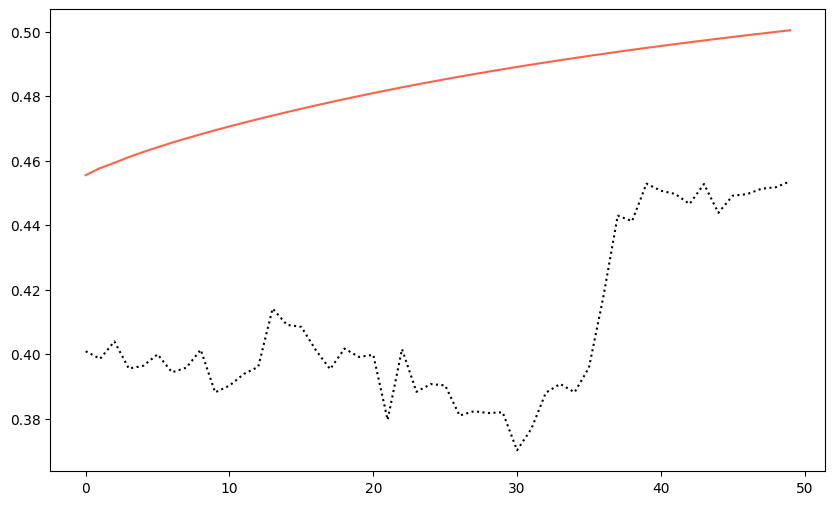

In [241]:
fig, ax = plt.subplots(1, 1)
ax.plot(series.flatten()[-NEXT_TIMESTEPS:], color='black', linestyle='dotted', label='real')
ax.plot(results, color='tomato', label='prediction')
plt.show()